## LSTM Training

In [1]:
#@title Import
import numpy as np
import os
import requests
import pandas as pd 
from pylab import mpl, plt
import seaborn as sns
plt.style.use('seaborn')
mpl.rcParams['font.family'] = "serif"
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

C:\Users\abc89\AppData\Local\Temp\ipykernel_19596\3892159902.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
#@title 台股總覽

# select stock number
data_id = "2330"
start_date = "2017-01-01"
end_date = "2023-06-01"
url = "https://api.finmindtrade.com/api/v4/data"

parameter = {
    "dataset": "TaiwanStockInfo",
    "token": ""
}
resp = requests.get(url, params = parameter)
data = resp.json()
data = pd.DataFrame(data["data"])
print(data)

     industry_category               stock_id stock_name  type        date
0                  ETF                   0050     元大台灣50  twse  2023-06-03
1                  ETF                   0051    元大中型100  twse  2023-06-03
2                  ETF                   0052       富邦科技  twse  2023-06-03
3                  ETF                   0053       元大電子  twse  2023-06-03
4                  ETF                   0054     元大台商50  twse  2023-06-03
...                ...                    ...        ...   ...         ...
3015                大盤                  TAIEX       加權指數  twse        None
3016             Index               Textiles    紡織纖維類指數  twse        None
3017             Index                Tourism    觀光事業類指數  twse        None
3018                大盤                   TPEx       櫃買指數  tpex        None
3019             Index  TradingConsumersGoods    貿易百貨類指數  twse        None

[3020 rows x 5 columns]


In [3]:
#@title 月營收表

parameter = {
    "dataset": "TaiwanStockMonthRevenue",
    "data_id": data_id,
    "start_date": start_date,
    "token": ""
}
data = requests.get(url, params = parameter)
data = data.json()
data = pd.DataFrame(data['data'])
data_revenue = pd.DataFrame()
count = 0 
for i in range(len(data)):
    for j in range(20):
        count += 1
        if count < len(data) * 20:
            a = pd.Series(data["revenue"][i])
            data_revenue = pd.concat([data_revenue, a])

In [4]:
#@title 台灣股票各項資料
parameter = {
    "dataset": "TaiwanStockPriceAdj",
    "start_date": start_date,
    "token": "",
    "data_id": data_id,                               
    "end_date": end_date
}

def get_data(dataset):
    parameter["dataset"] = dataset
    resp = requests.get(url, params = parameter)
    data = resp.json()
    return pd.DataFrame(data['data'])

data_price = get_data(dataset = "TaiwanStockPrice").drop({"stock_id"}, axis = 1)
# data_price = get_data(dataset = "TaiwanStockPrice")
data_PER_PBR = get_data("TaiwanStockPER").drop({"stock_id", "date"}, axis = 1)
data_volume = get_data("TaiwanStockDayTrading").drop({"stock_id", "date", "BuyAfterSale"}, axis = 1)
data_Margin_Trading_Short_Selling = get_data("TaiwanStockMarginPurchaseShortSale").drop({"stock_id", "date", "Note"}, axis = 1)
data_Foreign_capital = get_data("TaiwanStockShareholding").drop({"stock_id", "date", "stock_name", "NumberOfSharesIssued", "RecentlyDeclareDate", "InternationalCode"}, axis = 1)

concatenated_df = pd.concat([data_price, data_PER_PBR, data_volume, data_revenue.reset_index(), data_Margin_Trading_Short_Selling, data_Foreign_capital], axis = 1)
concatenated_df = concatenated_df.drop({"date", "index", "note"}, axis = 1)
# concatenated_df = concatenated_df.drop({"index", "note"}, axis = 1)
concatenated_df = concatenated_df.drop(index = [*range(len(data_price) - 1, len(concatenated_df["close"]))])
concatenated_df = concatenated_df.fillna(method = "pad", axis = 0)
concatenated_df.to_csv('data_' + data_id + '.csv', index = False)

In [5]:
#@title 讀取檔案與原始股價
data = pd.read_csv('data_' + data_id + '.csv')
price = data[['close']]
feature = data.shape[1]

In [6]:
#@title fitting 後的股價
scaler = MinMaxScaler(feature_range = (0, 1))
data = scaler.fit_transform(data.values.reshape(len(price), feature))
price['close'] = scaler.fit_transform(price['close'].values.reshape(-1, 1))
print(data.shape)
print(price[:-10])

(1563, 34)
         close
0     0.006951
1     0.006951
2     0.007944
3     0.008937
4     0.008937
...        ...
1548  0.634558
1549  0.628600
1550  0.627607
1551  0.646475
1552  0.674280

[1553 rows x 1 columns]


In [7]:
#@title data 讀取天數處理
def split_data(data, price, lookback):
    train_data = []
    
    # 每五天為一組，例如 lookback = 5 ，則 train_data append 進去 data[0:5]
    for index in range(len(data) - lookback): 
        train_data.append(data[index: index + lookback])
    
    train_data = np.array(train_data)
    train_data = train_data[:(len(train_data) - lookback)]
    price = np.array(price)
    price = price[lookback:]
    # 切割資料 10% 給 test 90% 給 train
    test_set_size = int(np.round(0.1 * train_data.shape[0]))
    train_set_size = train_data.shape[0] - (test_set_size)
    
    x_train = train_data[:train_set_size, :, :]
    y_train = price[:train_set_size]
    
    x_test = train_data[-test_set_size:, :]
    y_test = price[-test_set_size:]
    
    return x_train, y_train, x_test, y_test

In [8]:
#@title 讀取 data 並確認矩陣大小
lookback = 5 # choose sequence length
x_train, y_train, x_test, y_test = split_data(data, price, lookback)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor).to(device)

x_train.shape =  (1398, 5, 34)
y_train.shape =  (1398, 1)
x_test.shape =  (155, 5, 34)
y_test.shape =  (155, 1)


In [9]:
#@title Net

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # LSTM 內部隱藏維度
        self.hidden_dim = hidden_dim
        # LSTM 模型層數
        self.num_layers = num_layers       
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True).to(device)
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

    def forward(self, x):
        # h0 初始隱藏狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # c0 初始記憶狀態
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        #此時 out.shape = [總天數 295, 每 5 天為一組, hidden_dim]
        return self.fc(out[:, -1, :]).to(device)

class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim):
        super(CNNLSTM, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.conv1 = nn.Conv1d(1, 64, kernel_size = 3 , stride = 1, padding = 1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size = 3 , stride = 1, padding = 1)
        self.conv3 = nn.Conv1d(128, 64, kernel_size = 3 , stride = 1, padding = 1)
        self.pool = nn.MaxPool1d(2)
        self.bn1 = nn.BatchNorm2d(64)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc1 = nn.Linear(5376, input_size)
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = x.reshape(len(x), -1)
        x = x.unsqueeze(1)
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = x.reshape(len(x), -1)
        x = self.fc1(x) 
        x, _ = self.lstm(x) 
        return self.fc(x)

class GRU(nn.Module):
    def __init__(self, input, hidden, output, num_layer):
        super().__init__()
        self.gru = nn.GRU(input, hidden, num_layer)
        self.fc = nn.Linear(hidden, output)
        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, input):
        data, _ = self.gru(input)
        data = self.fc(data[:, -1, :])
        # data = self.dropout(data)
        return data
    
class MLP(nn.Module):
    def __init__(self, input, output):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input * lookback, 256)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(256, 128)
        self.fc = nn.Linear(128, output)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x= self.sigmoid(x)
        return self.fc(x)

# Parameter
input_dim = feature
hidden_dim = 128
num_layers = 2
output_dim = 1
num_epochs = 1000
"""Choose Model"""
def choose_model(model_type):  
    match model_type:  
        case 0:  
            return LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers), "LSTM" 
        case 1:  
            return CNNLSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = num_layers, output_dim = output_dim), "CNNLSTM"  
        case 2:  
            return GRU(input = input_dim, hidden = hidden_dim, output = output_dim, num_layer = num_layers), "GRU" 
        case 3:  
            return MLP(input = input_dim, output = output_dim), "MLP"   
        case _:  
            return LSTM(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, num_layers = num_layers), "LSTM"  
model_dict = {"LSTM" : 0, "CNNLSTM" : 1, "GRU" : 2, "MLP" : 3}
model_type = model_dict["CNNLSTM"]
model, name = choose_model(model_type)
"""Choose Model"""

criterion = nn.MSELoss(reduction = "mean")
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

model = model.to(device)
criterion = criterion.to(device)

In [10]:
#@title training
import time

train_loss = np.zeros(num_epochs)
test_loss = 0.0
start_time = time.time()
lstm = []

for i in range(num_epochs):
    optimizer.zero_grad()
    y_train_pred = model(x_train.to(device))
    loss = criterion(y_train_pred, y_train_lstm.to(device))
    print("=" * 29)
    print("|Epoch: ", i, "                |") 
    print("|MSE: ", round(loss.item(), 18), "|")
    loss.backward()
    optimizer.step()
    train_loss[i] = loss.item()

with torch.no_grad():
    y_test_pred = model(x_test.to(device))
    loss = criterion(y_test_pred.to(device), y_test_lstm.to(device))
    test_loss += loss.item()

print("=" * 29)
print("test_loss: ", test_loss)
training_time = time.time() - start_time
print("Training time: {}".format(training_time))

|Epoch:  0                 |
|MSE:  0.21685831248760223 |
|Epoch:  1                 |
|MSE:  0.15315192937850952 |
|Epoch:  2                 |
|MSE:  0.09756149351596832 |
|Epoch:  3                 |
|MSE:  0.11373506486415863 |
|Epoch:  4                 |
|MSE:  0.10158833861351013 |
|Epoch:  5                 |
|MSE:  0.08837000280618668 |
|Epoch:  6                 |
|MSE:  0.09122005850076675 |
|Epoch:  7                 |
|MSE:  0.09394025802612305 |
|Epoch:  8                 |
|MSE:  0.09094398468732834 |
|Epoch:  9                 |
|MSE:  0.08451574295759201 |
|Epoch:  10                 |
|MSE:  0.07749854028224945 |
|Epoch:  11                 |
|MSE:  0.07116825133562088 |
|Epoch:  12                 |
|MSE:  0.06437920033931732 |
|Epoch:  13                 |
|MSE:  0.05334522947669029 |
|Epoch:  14                 |
|MSE:  0.03902449086308479 |
|Epoch:  15                 |
|MSE:  0.024912778288125992 |
|Epoch:  16                 |
|MSE:  0.010928801260888577 |
|Epoc

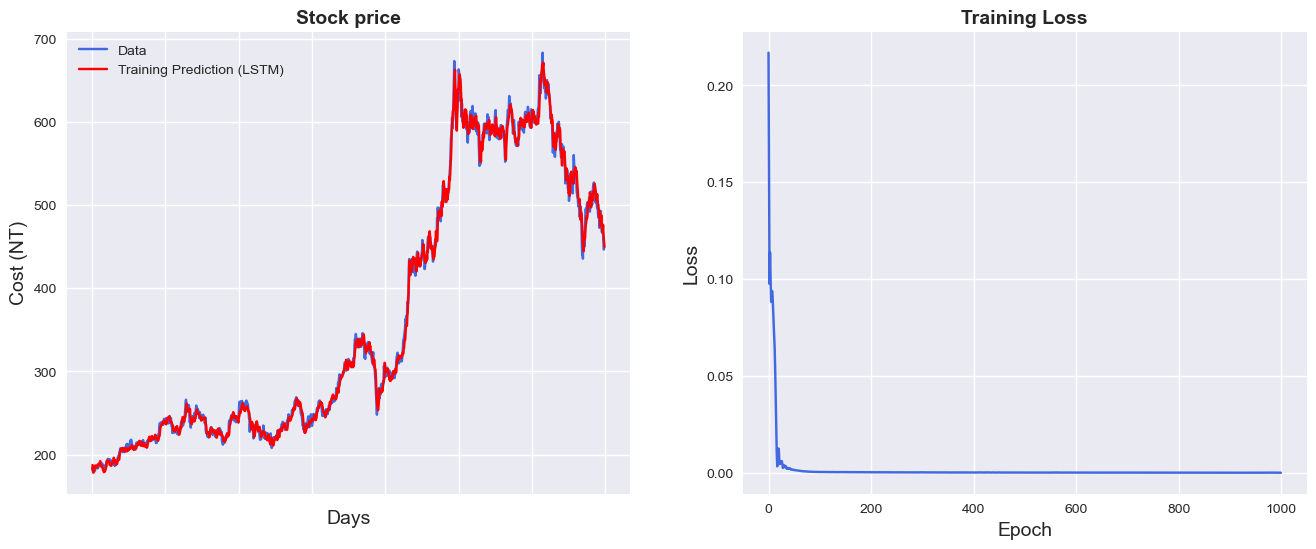

In [11]:
#@title train 結果
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.cpu().reshape(-1, 1).detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.cpu().detach().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace = 0.2, wspace = 0.2)

None if os.path.exists(name) else os.makedirs(name)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label = "Data", color = 'royalblue')
ax = sns.lineplot(x = predict.index + 1, y = predict[0], label = "Training Prediction (LSTM)", color = 'red')
ax.set_title('Stock price', size = 14, fontweight = 'bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (NT)", size = 14)
ax.set_xticklabels('', size = 10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data = train_loss, color = 'royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight = 'bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.savefig(name + "/train.png")

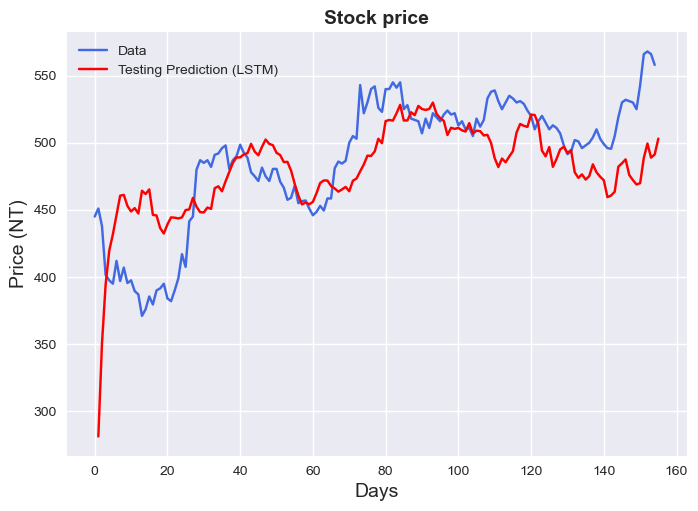

In [12]:
#@title test 結果
predict = pd.DataFrame(scaler.inverse_transform(y_test_pred.cpu().reshape(-1, 1).detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_test_lstm.cpu().detach().numpy()))

sns.set_style("darkgrid")    

fig = plt.figure()
ax = sns.lineplot(x = original.index, y = original[0], label = "Data", color = 'royalblue')
ax = sns.lineplot(x = predict.index + 1, y = predict[0], label = "Testing Prediction (LSTM)", color = 'red')
ax.set_title('Stock price', size = 14, fontweight = 'bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price (NT)", size = 14)
plt.savefig(name + "/test.png")

## RL Training

In [13]:
# import library
import time
import copy
import numpy as np
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import random
import torch
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)

In [14]:
data = pd.read_csv('data_2330_date.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
print(data.index.min(), data.index.max())
data.head()

2017-01-03 00:00:00 2023-05-31 00:00:00


,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,dividend_yield,PER,...,ShortSaleLimit,ShortSaleSell,ShortSaleTodayBalance,ShortSaleYesterdayBalance,ForeignInvestmentRemainingShares,ForeignInvestmentShares,ForeignInvestmentRemainRatio,ForeignInvestmentSharesRatio,ForeignInvestmentUpperLimitRatio,ChineseInvestmentUpperLimitRatio
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,23550783.0,4.300648e+09,181.5,183.5,181.0,183.0,1.5,8743.0,3.28,15.47,...,6482595.0,100.0,5174.0,5113.0,5513022528,20417357930,21.26,78.73,100.0,100.0
2017-01-04,24482374.0,4.478700e+09,183.0,184.0,181.5,183.0,0.0,8476.0,3.28,15.47,...,6482595.0,115.0,5271.0,5174.0,5517128765,20413251693,21.27,78.72,100.0,100.0
2017-01-05,21373561.0,3.913389e+09,182.0,183.5,181.5,183.5,0.5,8297.0,3.27,15.51,...,6482595.0,26.0,5258.0,5271.0,5513254008,20417126450,21.26,78.73,100.0,100.0
2017-01-06,23120808.0,4.250913e+09,184.0,184.5,183.5,184.0,0.5,9659.0,3.26,15.55,...,6482595.0,48.0,5288.0,5258.0,5509376419,20421004039,21.24,78.75,100.0,100.0
2017-01-09,18583788.0,3.419409e+09,184.0,185.0,183.0,184.0,0.0,5759.0,3.26,15.55,...,6482595.0,82.0,5335.0,5288.0,5506002982,20424377476,21.23,78.76,100.0,100.0


In [15]:
date_split = '2022-01-01'
train = data[:date_split]
test = data[date_split:]

len(train), len(test)
print(train)
print(test)

            Trading_Volume  Trading_money   open    max    min  close  spread  \
date                                                                            
2017-01-03      23550783.0   4.300648e+09  181.5  183.5  181.0  183.0     1.5   
2017-01-04      24482374.0   4.478700e+09  183.0  184.0  181.5  183.0     0.0   
2017-01-05      21373561.0   3.913389e+09  182.0  183.5  181.5  183.5     0.5   
2017-01-06      23120808.0   4.250913e+09  184.0  184.5  183.5  184.0     0.5   
2017-01-09      18583788.0   3.419409e+09  184.0  185.0  183.0  184.0     0.0   
...                    ...            ...    ...    ...    ...    ...     ...   
2021-12-24      12008673.0   7.276331e+09  606.0  609.0  604.0  604.0    -2.0   
2021-12-27      16771900.0   1.019346e+10  604.0  610.0  604.0  606.0     2.0   
2021-12-28      35156339.0   2.156951e+10  610.0  615.0  610.0  615.0     9.0   
2021-12-29      25604320.0   1.578804e+10  615.0  619.0  614.0  616.0     1.0   
2021-12-30      20522055.0  

In [16]:
# canndle stick char
def plot_train_test(train, test, data_split):

    data = [
        Candlestick(x = train.index, open = train['open'], high = train['max'], low = train['min'], close = train['close'], name = 'train'),
        Candlestick(x = test.index, open = test['open'], high = test['max'], low = test['min'], close = test['close'], name = 'test'),
    ]
    layout = {
        'shapes': [
            {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
        ],
        'annotations':[
            {'x': data_split, 'y':1.0, 'xref':'x', 'yref':'paper', 'showarrow':False,  'xanchor':'left', 'text':'test data'},
            {'x': data_split, 'y':1.0, 'xref':'x', 'yref':'paper', 'showarrow':False,  'xanchor':'right', 'text':'train data'}
        ]
    }

    figure = Figure(data = data, layout = layout)
    iplot(figure)

plot_train_test(train, test, date_split)


In [17]:
class Environment1: #collect data
    def __init__(self, data, history_t = 90): 
        self.data = data # The historical price data
        self.history_t = history_t # The number of time steps to consider for state representation
        self.reset() # Initialize the environment
        self.money = 3 # The initial amount of money

    def reset(self):
        self.t = 0 # Reset the time step to 0
        self.money = 3 # Reset the time step to 0
        self.done = False # Set the episode as non-terminal
        self.profits = 0 # Initialize the total profits to 0
        self.position = [] # Initialize the inventory to an empty list
        self.position_value = 0 # Initialize the inventory value to 0
        self.history = [0 for _ in range(self.history_t)] # Initialize the price history
        return [self.position_value] + self.history  # Return the state vector (observation)
    
    def step(self, act):
        reward = 0 # Initialize the reward as 0

        # act = 0: Stay, act = 1: Buy, act = 2: Sell
        #print('money', self.money)
        if act == 1: # Buy #買只能一次買一張
            if self.money == 0:
                reward = -10
            else:
                self.position.append(self.data.iloc[self.t, :]["close"]) #買入
                self.money -= 1
            # print("Buy at: ", self.data.iloc[self.t, :]["Close"]) # add the current price to the position
        elif act == 2: # Sell #賣就會把一次所有的股票賣掉
            if len(self.position) == 0:
                reward = -10
                # print("Sell at: ", self.data.iloc[self.t, :]["Close"]) #賣出
            else:
                profits = 0 # profit是已實現損益
                for p in self.position:
                    profits += (self.data.iloc[self.t, :]["close"] - p)
                reward += profits
                self.money = 3
                self.profits += profits
                self.position = []
        self.t += 1 # Increment the time step by 1
        self.position_value = 0
        for p in self.position:
            self.position_value += (self.data.iloc[self.t, :]["close"] - p) #持有的股票價值
        self.history.pop(0) #移除第一個
        self.history.append(self.data.iloc[self.t, :]["close"] - self.data.iloc[(self.t - 1), :]["close"]) #加入最後一個 

        # if reward >0:
        #     reward = 1
        # elif reward < 0:
        #     reward = -1

        return [self.position_value] + self.history, reward, self.done
        

In [18]:
env = Environment1(train)
# print(env.reset())

for _ in range(15): # Run for 3 days
    pact = np.random.randint(3) # Pick a random action
    #state, reward, done = env.step(pact)
    # print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [19]:
def train_dqn(env):

    class Q_Network(chainer.Chain):
        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y
        
        def reset(self):
            self.zerograds()


    print(env.history_t + 1)
    Q = Q_Network(input_size=env.history_t + 1, hidden_size=100, output_size=3) # 創建一個model
    Q_ast = copy.deepcopy(Q) # 創建一個目標model
    optimizer = chainer.optimizers.Adam() # 創建一個optimizer
    optimizer.setup(Q) # 將model放入optimizer

    # Hyperparameters
    epoch_num = 100
    print("step_max: ", len(env.data)-1)
    step_max = len(env.data)-1 # 一共有多少天拿來訓練 (445)
    memory_size = 200
    batch_size = 20
    epsilon = 1.0 # 探索率 (隨機選擇動作的機率) 
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 1

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset() # reset history & position value
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max: # 一直到遊戲結束或是超過step_max(玩到最後)才會停下來 #開始玩遊戲

            # select act
            pact = np.random.randint(3) # 給予隨機的動作(0-2)
            
            # 小於epsilon就探索
            if np.random.rand() > epsilon: # 如果大於epsilon(探索率)，就從Q_network中選擇最好的動作，否則就隨機選擇，直到epsilon小於epsilon_min，就不會再隨機選擇，而是從Q_network中選擇最好的動作，epislon會隨著時間遞減(from 1 to 0.1)
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)
        
            # act
            obs, reward, done = env.step(pact) # 執行動作，並且得到新的狀態、獎勵、是否結束
            #print(len(obs))
            # add memory
            memory.append((*pobs, pact, reward, *obs, done)) # 把狀態、動作、獎勵、新的狀態、是否結束放入memory
            # print(memory)
            if len(memory) > memory_size: # 如果memory超過memory_size，就把最舊的memory pop掉 (memory_size = 200)
                memory.pop(0)

            # train or update Q
            if len(memory) == memory_size: # 如果memory等於memory_size，就開始訓練 防呆用
                if total_step % train_freq == 0: # 每train_freq次就訓練一次 (train_freq = 10) #每玩10次就訓練一次 #此時memory 會多10天的資料
                    #print(len(memory))
                    #print(memory[1][3])
                    shuffled_memory = memory #np.random.permutation(memory) ## check #shuffle怪怪的
                    memory_idx = range(len(shuffled_memory))

                    #print(memory[0:2])
                    # for x in range(200):
                    #     print(len(shuffled_memory[x]))
                    


                    for i in memory_idx[::batch_size]: # 每次從memory中隨機選擇batch_size(20)筆資料來訓練
                        # batch = shuffled_memory[i:i + batch_size]
                        # print(batch[0])
                        # print(batch[1])
                        # print(batch[2])
                        # print(batch[3])
                        # print(batch[4])
                        batch = np.array(shuffled_memory[i:i+batch_size], dtype=np.float32)




                        b_pobs = np.array(batch[:, :91].tolist(), dtype=np.float32).reshape(batch_size, -1 ) # batcg_size = 20 b_pobs = 20*91
     
                        b_pact = np.array(batch[:, 91].tolist(), dtype=np.int32) # b_pact = 20*1
                        b_reward = np.array(batch[:, 92].tolist(), dtype=np.int32) #    b_reward = 20*1
                        b_obs = np.array(batch[:, 93:184].tolist(), dtype=np.float32).reshape(batch_size, -1) # b_obs = 20*91
                        b_done = np.array(batch[:, 184].tolist(), dtype=bool) # b_done = 20*1

                        q = Q(b_pobs) # q = 20*3 q是預測的動作  #用pobs去預測動作 #pobs是前一天的狀態
                        # maxq = np.max(q.data, axis=1) # maxq = 20*1 #用obs去預測動作 #obs是當天的狀態 #把這20天的obs丟進去，會得到20組3個動作的q值，取最大的那個q值
                        # maxq0 = np.max(q.data, axis=1)
                        # print('maxq0',maxq0)
                        # maxq1 = np.max(Q_ast(b_pobs).data, axis=1)
                        # print('maxq1',maxq1)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        # print('maxq2',maxq2)
                        target = copy.deepcopy(q.data) # target = 20*3 #把q.data複製一份給target
                        for j in range(batch_size): # 一次訓練20筆資料
                            target[j, b_pact[j]] = b_reward[j] + gamma * maxq[j] * (not b_done[j]) # target = 20*3 #如果還沒結束，就用reward加上gamma乘上maxq，如果已經結束，就只用reward，並把這個數值放在target每天動作矩陣中的最大值那一個位置
                            #gamma = 0.99
                        Q.reset() 
                        loss = F.mean_squared_error(q, target) # q是預測的動作，target是想要的動作，用這兩個來計算loss
                        total_loss += loss.data 
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0: # 每update_q_freq次就把Q的權重給Q_ast #update_q_freq = 20
                    Q_ast = copy.deepcopy(Q)

            # epsilon #每玩一天都會更新一次epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon: # 更新探索率 #epsilon_min = 0.1 意即最多也還會有10%機率瞎猜， #start_reduce_epsilon = 1000
                epsilon -= epsilon_decrease # epsilon_decrease = 0.001

            # next step
            total_reward += reward 
            pobs = obs # pobs = 20,91 #把當天的狀態存起來，當作下一天的前一天狀態
            step += 1
            total_step += 1

    
        # 出來while迴圈後，就是一次episode結束，把這次episode的total_reward和total_loss存起來
        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch + 1) % show_log_freq == 0: # 每show_log_freq次就印出來 #show_log_freq = 1
            log_reward = sum(total_rewards[((epoch + 1) - show_log_freq):]) / show_log_freq
            log_loss = sum(total_losses[((epoch + 1) - show_log_freq):]) / show_log_freq
            elapse_time = time.time() - start
            print('epoch: {:3} | epsison: {:.4f} | total_step: {:6d} | log_reward: {:8.1f} | log_loss: {:10.4f} | time: {:.4f}'  .format(epoch + 1, epsilon, total_step, log_reward, log_loss, elapse_time))
            start = time.time()

    # save model
    # Q.save_model("model.pkl")
    return Q, total_losses, total_rewards

Q, total_losses, total_rewards = train_dqn(Environment1(train))

91
step_max:  1223
epoch:   1 | epsison: 0.1000 | total_step:   1223 | log_reward:  -1288.0 | log_loss: 29087.2263 | time: 3.7600
epoch:   2 | epsison: 0.1000 | total_step:   2446 | log_reward:   -303.5 | log_loss: 35301.3369 | time: 4.5276
epoch:   3 | epsison: 0.1000 | total_step:   3669 | log_reward:   -591.0 | log_loss: 12463.1006 | time: 4.6368
epoch:   4 | epsison: 0.1000 | total_step:   4892 | log_reward:   -361.0 | log_loss: 10003.1303 | time: 4.7662
epoch:   5 | epsison: 0.1000 | total_step:   6115 | log_reward:     11.0 | log_loss: 11320.5489 | time: 4.3967
epoch:   6 | epsison: 0.1000 | total_step:   7338 | log_reward:     36.0 | log_loss: 21495.6718 | time: 4.1689
epoch:   7 | epsison: 0.1000 | total_step:   8561 | log_reward:   -265.0 | log_loss: 13764.7461 | time: 4.0227
epoch:   8 | epsison: 0.1000 | total_step:   9784 | log_reward:     97.5 | log_loss: 19897.5128 | time: 3.9205
epoch:   9 | epsison: 0.1000 | total_step:  11007 | log_reward:     80.5 | log_loss: 19314.61

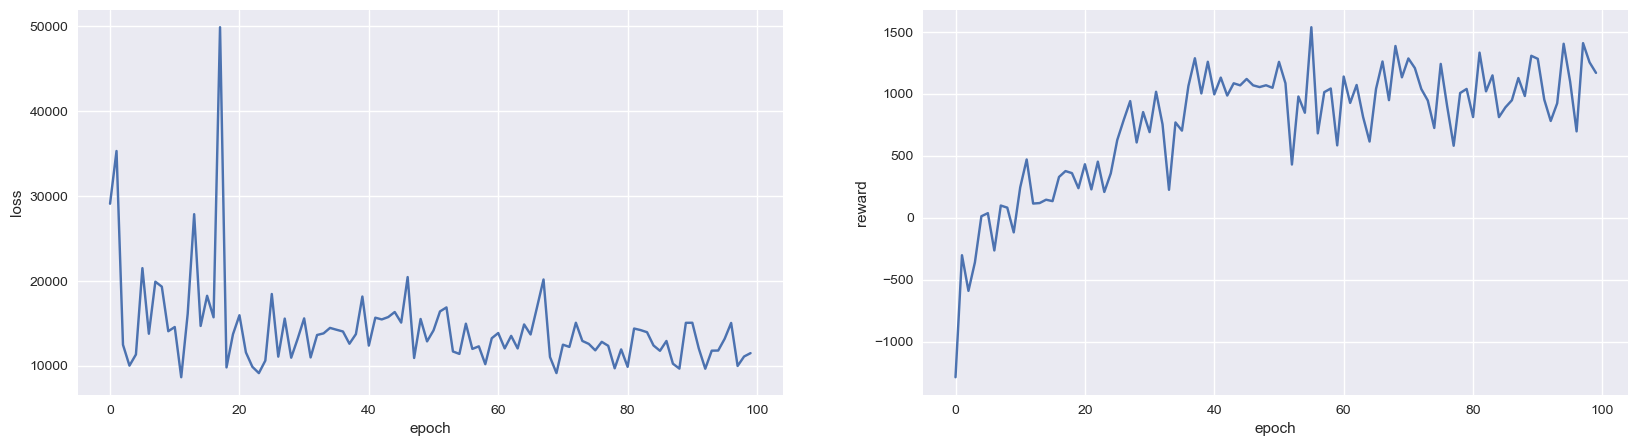

In [20]:
def plot_loss_reward(total_losses, total_rewards):
    fig = plt.figure(figsize=(20, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(total_losses)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")
    ax2.plot(total_rewards)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("reward")
    plt.show()

plot_loss_reward(total_losses, total_rewards)

In [21]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):

    # train
    pobs = train_env.reset()   
    train_acts = []
    train_rewards = []

    for _ in range(len(train_env.data)-1):
        pact = Q(np.array(pobs, dtype =  np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)

        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs


    train_profits = train_env.profits

    # test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data) - 1):

        pact = Q(np.array(pobs, dtype =  np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)

        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs


    test_profits = test_env.profits

    #plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0 ]
    train1 = train_copy[train_copy['act'] == 1 ]
    train2 = train_copy[train_copy['act'] == 2 ]

    test0 = test_copy[test_copy['act'] == 0 ]
    test1 = test_copy[test_copy['act'] == 1 ]
    test2 = test_copy[test_copy['act'] == 2 ]

    act_color0, act_color1, act_color2 = 'grey', 'royalblue', 'tomato'


    data = [
        Candlestick(x = train0.index, open = train0['open'], high = train0['max'], low = train0['min'], close = train0['close'], increasing = dict(line = dict(color = act_color0)), decreasing = dict(line = dict(color = act_color0))),
        Candlestick(x = train1.index, open = train1['open'], high = train1['max'], low = train1['min'], close = train1['close'], increasing = dict(line = dict(color = act_color1)), decreasing = dict(line = dict(color = act_color1))),
        Candlestick(x = train2.index, open = train2['open'], high = train2['max'], low = train2['min'], close = train2['close'], increasing = dict(line = dict(color = act_color2)), decreasing = dict(line = dict(color = act_color2))),
        Candlestick(x = test0.index, open = test0['open'], high = test0['max'], low = test0['min'], close = test0['close'], increasing = dict(line = dict(color = act_color0)), decreasing = dict(line = dict(color = act_color0))),
        Candlestick(x = test1.index, open = test1['open'], high = test1['max'], low = test1['min'], close = test1['close'], increasing = dict(line = dict(color = act_color1)), decreasing = dict(line = dict(color = act_color1))),
        Candlestick(x = test2.index, open = test2['open'], high = test2['max'], low = test2['min'], close = test2['close'], increasing = dict(line = dict(color = act_color2)), decreasing = dict(line = dict(color = act_color2))),
    
    ]
    title = '{}: train\'s-reward: {}, profits: {}, test\'s-reward: {}, profits: {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    )
    layout = {
        'title': title,
        'showlegend': False,
        'shapes': [
            {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0, 0, 0)', 'width': 1}},

        ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': 'test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data'},
        ]
    }
    figure = Figure(data = data, layout = layout)
    iplot(figure, image_width = 50, image_height = 50)

plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'DQN')